# **Calcul des déformations de la surface de la Terre induites par les surcharges de GRACE**
## Cours de Charges climatiques et déformations de la Terre - M2 Géophysique 2022-2023
Kristel Chanard & Laurent Métivier
(lalmetiv@ipgp.fr)

<font color=blue> **Import des librairies** </font>

Une librairie python très pratique pour les calculs en harmoniques sphériques existe : https://shtools.github.io/SHTOOLS/.

Pour installer pyshtools:

1. pip install pyshtools
2. pip install --upgrade pyshtools  # to upgrade a pre-existing installation
3. conda install -c conda-forge pyshtools  # Linux and macOS only

In [1]:
# Imports
import os
import pickle
from math import pi, sqrt, cos, sin
import numpy as np
import pyshtools   
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Fonction de plot cartopy

def plot_cartopy_sh_grid(grid):
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')

    # c = ax.contourf(grid3.lons(), grid3.lats(), grid3.data, transform=ccrs.PlateCarree(), cmap='viridis')

    lon,lat = grid.lons(), grid.lats()
    c = ax.imshow(grid.data, extent=[lon.min(),lon.max(),lat.min(),lat.max()], transform=ccrs.PlateCarree(), cmap='bwr')

    cbar = plt.colorbar(c, ax=ax, orientation='vertical', label='', shrink=0.5)
    
    return fig,ax,cbar

def plot_cartopy(lat,lon,data):
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')

    # c = ax.contourf(grid3.lons(), grid3.lats(), grid3.data, transform=ccrs.PlateCarree(), cmap='viridis')

    lon,lat = lon,lat
    c = ax.imshow(data, extent=[lon.min(),lon.max(),lat.min(),lat.max()], transform=ccrs.PlateCarree(), cmap='bwr')

    cbar = plt.colorbar(c, ax=ax, orientation='vertical', label='', shrink=0.5)
    
    return fig,ax,cbar

<font color=blue> **Lecture des données** </font>. 

Nous utilisons une solution GRACE mensuelle donnée sous forme de coefficients de Stokes, c'est-à-dire non pas les coefficients de la décomposition en harmoniques sphériques de la charge, mais ceux normalisés du champ de pesanteur terrestre.

Les données sont traitées par plusieurs centres de calcul, adoptant des stratégies différentes, et sont télécharchables en ligne. Ici on choisit les données de CSR (UTexas)


In [3]:
(l, m, C, S) = np.loadtxt('../GRACE_data/GSM-2_2012032-2012060_GRAC_UTCSR_BA01_0600', skiprows=125, usecols=range(1, 5), dtype='i,i,d,d', unpack=True)

On définit le degré maximal des données GRACE, c'est à dire le degré de troncature de la décomposition en harmoniques sphériques

In [4]:
lmax = np.max(l)
print(lmax)

60


On range les coefficients de Stokes dans un seul tableau Clm de taille (2, lmax+1, lmax+1) pour pyshtools.

In [5]:
Clm = np.zeros((2, lmax+1, lmax+1))
for i in range(len(l)):
    Clm[0, l[i], m[i]] = C[i]
    Clm[1, l[i], m[i]] = S[i]

On peut tracer les données brutes pour voir à quoi ressemble le champ de gravité GRACE à une date donnée

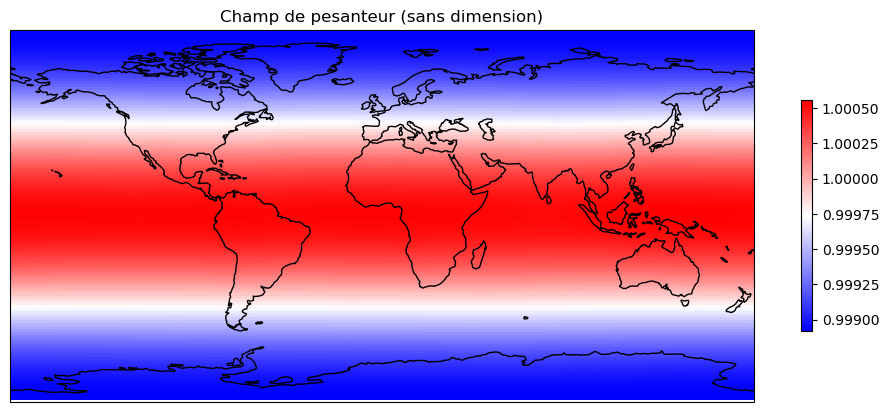

In [6]:
# On construit un objet pyshtools.SHCoeffs à partir de ce tableau.
Clm_sh = pyshtools.SHCoeffs.from_array(Clm)

# On le transforme en grille
grid = Clm_sh.expand()

# On trace les coefficients du champ de gravité sur une grille lon/lat
# Ici on trace simplement avec matplotlib mais il est conseillé d'ajouter projections/côtes etc. (avec matplotlib : https://matplotlib.org/basemap/api/basemap_api.html ou avec cartopy par exemple)

fig,ax,cbar = plot_cartopy_sh_grid(grid)

plt.title('Champ de pesanteur (sans dimension)')
plt.show()

<font color=blue> **Traitement des données** </font>

Afin d'observer uniquement les variations du champ de gravité sur toute la série temporelle GRACE, il va donc falloir retirer un champ de gravité moyen de la solution GRACE mensuelle.

In [8]:
(l, m, C, S) = np.loadtxt('../GRACE_data/GSM-2_2009152-2009181_GRAC_UTCSR_BA01_0600', skiprows=125, usecols=range(1, 5), dtype='i,i,d,d', unpack=True)

for i in range(len(l)):
    if (l[i] <= lmax):
        Clm[0, l[i], m[i]] = Clm[0, l[i], m[i]] - C[i]
        Clm[1, l[i], m[i]] = Clm[1, l[i], m[i]] - S[i]
        
# On construit un objet pyshtools.SHCoeffs à partir de ce tableau.
Clm_sh = pyshtools.SHCoeffs.from_array(Clm)

grid2 = Clm_sh.expand()

On peut tracer les anomalies du champ de gravité corrigées du champ moyen.

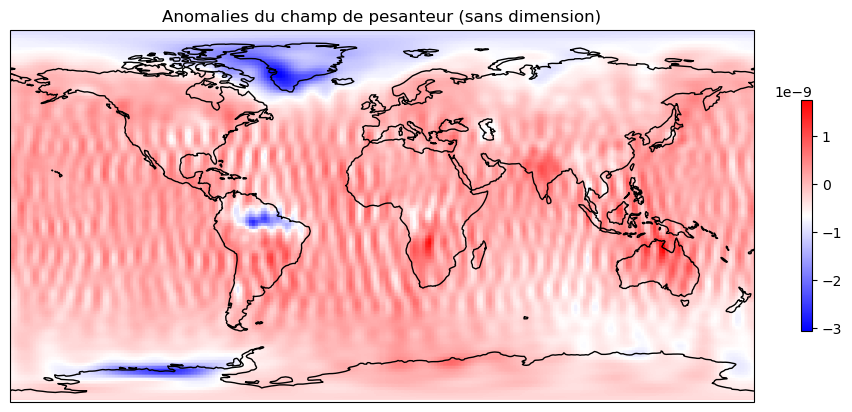

In [9]:
# On trace les coefficients du champ de gravité sur une grille lon/lat
# Ici on trace simplement avec matplotlib mais il est conseillé d'ajouter projections/côtes etc. (avec matplotlib : https://matplotlib.org/basemap/api/basemap_api.html ou avec cartopy par exemple)

fig,ax,cbar = plot_cartopy_sh_grid(grid2)

plt.title('Anomalies du champ de pesanteur (sans dimension)')
plt.show()

On remarque des stries Nord-Sud qui sont liées aux erreurs de traitement des données GRACE qu'on va donc filtrer à l'aide du filtre "DDK5".
Ce filtre s'applique directement aux coefficients de Stokes.

Ses coefficients se trouvent dans le fichier DDK5.pickle.

In [44]:
W = pickle.load(open('DDK5.pickle', 'rb'))
Clm[0,2:lmax+1,0] = np.dot(W[0,0].T[:lmax-1,:lmax-1], Clm[0,2:lmax+1,0])
Clm[0,2:lmax+1,1] = np.dot(W[0,1].T[:lmax-1,:lmax-1], Clm[0,2:lmax+1,1])
Clm[1,2:lmax+1,1] = np.dot(W[1,1].T[:lmax-1,:lmax-1], Clm[1,2:lmax+1,1])
for m in range(2, lmax+1):
    Clm[0,m:lmax+1,m] = np.dot(W[0,m].T[:lmax+1-m,:lmax+1-m], Clm[0,m:lmax+1,m])
    Clm[1,m:lmax+1,m] = np.dot(W[1,m].T[:lmax+1-m,:lmax+1-m], Clm[1,m:lmax+1,m])
    
# On construit un objet pyshtools.SHCoeffs à partir de ce tableau.
Clm_sh = pyshtools.SHCoeffs.from_array(Clm)

grid3 = Clm_sh.expand()

On peut maintenant tracer le champ de gravité filtré.

C'est un peu plus propre, et on distingue des signaux hydrologiques (fonte des glaces au Groenland et en Alaska, période sèche en Amazonie, période humide en Asie du Sud-Est, etc).

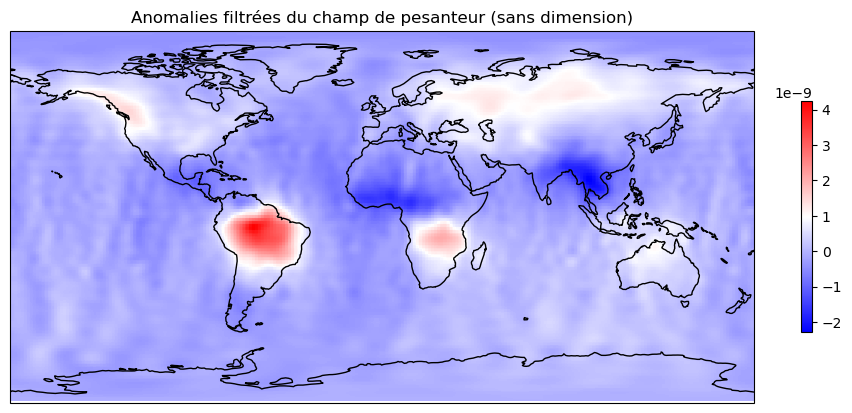

In [50]:
fig,ax,cbar = plot_cartopy_sh_grid(grid3)

plt.title('Anomalies filtrées du champ de pesanteur (sans dimension)')
plt.show()

<font color=blue> **Conversion des données en Hauteur d'eau équivalente** </font>

Convertissons maintenant les coefficients de Stokes en coefficients de la décomposition en harmoniques sphériques de la charge, grâce à l'équation (14) de cet article : https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98JB02844
On a besoin pour cela du rayon moyen de la Terre (ae), de sa densité moyenne (rhoe), de la densité moyenne de l'eau (rhow) et des nombres de Love de pesanteur k(l).
La charge obtenue est exprimée en hauteur d'eau équivalente, en mètres.

In [11]:
ae = 6371000. # [m]
rhoe = 5514.  # [kg/m^3]
rhow = 1000.  # [kg/m^3]
(hlove, llove, klove) = np.loadtxt('Load_Love2_CF.dat', usecols=range(1, 4), unpack=True)
hlm = np.zeros((2, lmax+1, lmax+1))
for l in range(1, lmax+1):
    hlm[:,l,:] = rhoe*ae*(2*l+1) / (3*rhow*(1+klove[l])) * Clm[:,l,:]

Regardons la carte des anomalies du champ de gravité exprimées en hauteur d'eau équivalente.

C'est toujours bien strié... la réalité des données.

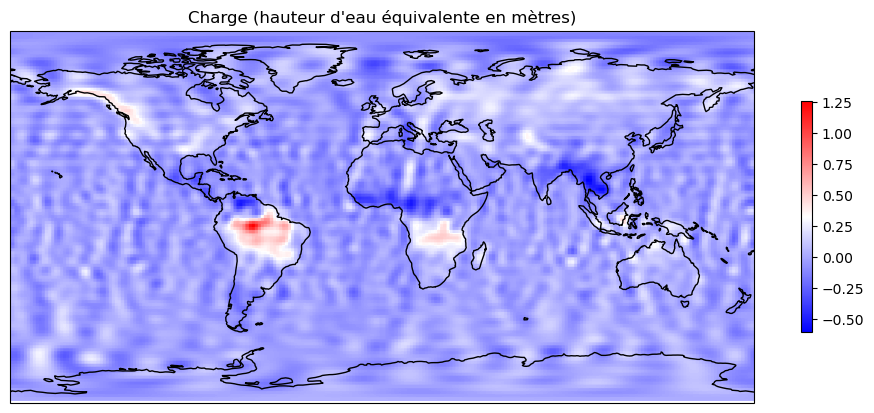

In [51]:
hlm_sh = pyshtools.SHCoeffs.from_array(hlm)
gridh = hlm_sh.expand()

fig,ax,cbar = plot_cartopy_sh_grid(gridh)

plt.title('Charge (hauteur d\'eau équivalente en mètres)')
plt.show()

<font color=blue> **Calcul de déformation** </font>

Passons maintenant au calcul des coefficients en harmoniques des déformations de la Terre dues à cette charge.

A partir des coefficients Clm de la décomposition en harmoniques sphériques d’une charge, on peut directement obtenir les coefficients Ulm du déplacement radial
correspondant par :

$\begin{equation}
U_{lm} = \frac{a_e* h(l)}{1+k(l)}*\sigma_{lm}
\end{equation}$


Il suffit ensuite de recomposer le deplacement radial (vertical) pour tous les harmoniques

$\begin{equation}
U(\theta,\phi) = \sum_{l=0}^{\infty} \sum_{m=-l}^{m=+l} U_{lm} Y_{lm}(\theta,\phi)
\end{equation}$

où $Y_{lm}$ sont les fonctions associées aux polynomes de Legendre


In [13]:
# Coefficients en harmoniques sphériques des déplacements verticaux
Ulm = np.zeros(Clm.shape)
for l in range(1, lmax+1):
    Ulm[:,l,:] = ae*hlove[l]/(1+klove[l]) * Clm[:,l,:]
Ulm = pyshtools.SHCoeffs.from_array(Ulm)

Pour les déplacements tangentiels (est, nord), c'est un peu plus compliqué. 
Les équations sont données dans ce qui suit pour information, mais le TD se concentrera sur les déplacements verticaux.

In [14]:
# Coefficients en harmoniques sphériques de la 1ère partie des déplacements vers le Nord (celle qui sera à multiplier par tan(latitude))
N1lm = np.zeros(Clm.shape)
for l in range(1, lmax+1):
    for m in range(l+1):
        N1lm[:,l,m] = -ae*llove[l]/(1+klove[l])*l * Clm[:,l,m]
N1lm = pyshtools.SHCoeffs.from_array(N1lm)

In [15]:
# Coefficients en harmoniques sphériques de la 2ème partie des déplacements vers le Nord (celle qui sera à diviser par cos(latitude))
N2lm = np.zeros(Clm.shape)
for l in range(1, lmax+1):
    for m in range(l+1):
        N2lm[:,l-1,m] = ae*llove[l]/(1+klove[l])*sqrt(float(2*l+1)/(2*l-1)*(l+m)*(l-m)) * Clm[:,l,m]
N2lm = pyshtools.SHCoeffs.from_array(N2lm)

In [16]:
# Coefficients en harmoniques sphériques des déplacements vers l'Est (qui seront à diviser par cos(latitude))
Elm = np.zeros(Clm.shape)
for l in range(1, lmax+1):
    for m in range(l+1):
        Elm[0,l,m] =  ae*llove[l]/(1+klove[l])*m * Clm[1,l,m]
        Elm[1,l,m] = -ae*llove[l]/(1+klove[l])*m * Clm[0,l,m]
Elm = pyshtools.SHCoeffs.from_array(Elm)

In [63]:
# Et passons enfin au calcul des déformations en un certain nombre de points. Ici, pour l'exemple, on va faire ça sur une grille 1° x 1°.
# Voici la grille :
lon = np.arange(-179.5, 180, 1)
lat = np.arange(-89.5, 90, 1)
(lon, lat) = np.meshgrid(lon, lat)

In [64]:
# Les latitudes en radians
phi = pi/180*lat

In [65]:
# Le calcul des déplacements :
dE = Elm.expand(lon=lon, lat=lat)/np.cos(phi)
dN = N1lm.expand(lon=lon, lat=lat)*np.tan(phi) + N2lm.expand(lon=lon, lat=lat)/np.cos(phi)
dU = Ulm.expand(lon=lon, lat=lat)

In [67]:
dU.shape

(180, 360)

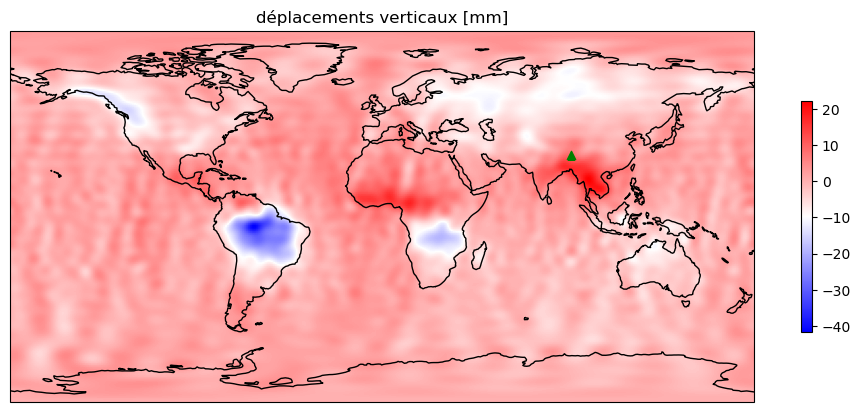

In [78]:
fig,ax,cbar = plot_cartopy(lat, lon, dU[::-1,:]*1e3)

ax.scatter(-268.895977,29.65733, transform=ccrs.PlateCarree(), zorder=10, c="g", marker="^")

plt.title('déplacements verticaux [mm]')
plt.show()

Nous avons fait le calcul pour une date GRACE, nous souhaitons maintenant regarder une série temporelle des déplacements verticaux induits par GRACE et les comparer à des mesures GNSS.
A vous de jouer ! 